<a href="https://colab.research.google.com/github/Whale-way/happy-whale/blob/Classification/Classification_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Baseline model for image classification

- we use the segmented dataset of: https://www.kaggle.com/datasets/adnanpen/background-removed-happywhale-dataset/code?select=seg_img 
- Final goal for the output is 5 suggestions for the matching photo-ID (or the suggestion that it is a new animal)


First ideas/thoughts:

- clean the csv (misspellings in the species)
- get an overview about the number of species and individuals/pictures per individual
- try to classify the species first
- choose a subset (100) images to build a baseline with SVM sckitlearn


Prep System / Packages etc.


In [21]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

import random
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, InputLayer, Flatten
from tensorflow.keras.models import Sequential, Model
import matplotlib.image as mpimg

from os import listdir
from os.path import isfile, join
import re

from PIL import Image
import glob

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "drive/Shareddrives/When there\'s a whale there\'s a way/"
CHAPTER_ID = "Classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [20]:
PROJECT_ROOT_DIR

'.'

Checking out the data 

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
datapath = os.path.join("drive", "Shareddrives", "When there's a whale there's a way", "input", "sample_segmented_images", "")


In [4]:
train_df = pd.read_csv(datapath + "seg_train_sample_100.csv", sep = ';')


In [5]:
train_df.head(10)

,image,species,individual_id
0,0a572d02a1ed8e.png,minke_whale,0940fc2c3809
1,0a0ae8699f1a5a.png,beluga,af02c0601c6e
2,0a0cedc8ac6499.png,melon_headed_whale,fa870e1ae82d
3,0a0d83708b4fdc.png,bottlenose_dolphin,c2705f9e75c8
4,0a0e4b82b9f3ee.png,humpback_whale,02f5c5ee9c2a
5,0a0e90fb154acf.png,false_killer_whale,f7bb4f9a9d1a
6,0a0f53c069bffc.png,spinner_dolphin,1b9d07e72110
7,0a01b620a7915b.png,blue_whale,7c9f2b782eed
8,0a1bcf1da2b695.png,beluga,d53bc5d9dbfe
9,0a1c741127059b.png,bottlenose_dolphin,a43daee90cbc


In [6]:
train_df['species']. value_counts()

beluga                       20
bottlenose_dolphin           17
humpback_whale               16
blue_whale                    7
spinner_dolphin               6
minke_whale                   4
false_killer_whale            4
kiler_whale                   3
melon_headed_whale            3
bottlenose_dolpin             2
long_finned_pilot_whale       2
common_dolphin                2
dusky_dolphin                 2
short_finned_pilot_whale      2
fin_whale                     2
pantropic_spotted_dolphin     1
killer_whale                  1
cuviers_beaked_whale          1
southern_right_whale          1
gray_whale                    1
spotted_dolphin               1
pilot_whale                   1
pygmy_killer_whale            1
Name: species, dtype: int64

we have some typos in the species:
- but we have bottlenose_dolphin and bottlenose_dolpin, kiler_whale and killer_whale. Obviously, it is typos. Also, globis and pilot_whale are short_finned_pilot_whale

--> correct the labels

In [7]:
train_df.species.replace({"globis": "short_finned_pilot_whale",
                          "pilot_whale": "short_finned_pilot_whale",
                          "kiler_whale": "killer_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin"}, inplace=True)

In [8]:
train_df['species']. value_counts()

beluga                       20
bottlenose_dolphin           19
humpback_whale               16
blue_whale                    7
spinner_dolphin               6
minke_whale                   4
killer_whale                  4
false_killer_whale            4
melon_headed_whale            3
short_finned_pilot_whale      3
long_finned_pilot_whale       2
common_dolphin                2
dusky_dolphin                 2
fin_whale                     2
pantropic_spotted_dolphin     1
cuviers_beaked_whale          1
southern_right_whale          1
gray_whale                    1
spotted_dolphin               1
pygmy_killer_whale            1
Name: species, dtype: int64

In [9]:
y = train_df["species"]

In [10]:
y.shape

(100,)

Loading the Images

Define paths to data - here to 100 sample pictures

In [22]:
ROOT_PATH_DATA = "drive/Shareddrives/When there\'s a whale there\'s a way/input/"
PATH_DATA_TRAIN_SAMPLE = os.path.join(ROOT_PATH_DATA + "sample_segmented_images/seg_train_sample_100")

In [23]:
# Defining function to list all pictures to include
def list_files(dir):
    r = []
    for root, dirs, files in os.walk(dir):
        for name in files:
            r.append(os.path.join(root, name))
    return r

In [24]:
filepaths_train_sample = list_files(PATH_DATA_TRAIN_SAMPLE)

In [25]:
### i don't know if we gonna need that
# Extract pic ids from files in consideration
#Correct pic ids
pic_ids_train_sample = np.array([])
for i in range(len(filepaths_train_sample)):
    file_short = filepaths_train_sample[i].replace(PATH_DATA_TRAIN_SAMPLE + "/", "SAMPLE/")
    pic_ids_train_sample = np.append(pic_ids_train_sample, file_short)

In [26]:
image_list = []
for filename in glob.glob(os.path.join(PATH_DATA_TRAIN_SAMPLE +'/*.png')):
    im=Image.open(filename)
    image_list.append(im)

In [27]:
plt.figure(figsize=(50,50))
example_images = image_list[:10]
plot_digits(example_images, images_per_row=5)
save_fig("sample_image_plot")
plt.show()

NameError: ignored

<Figure size 3600x3600 with 0 Axes>

Saving figure sample_image_plot


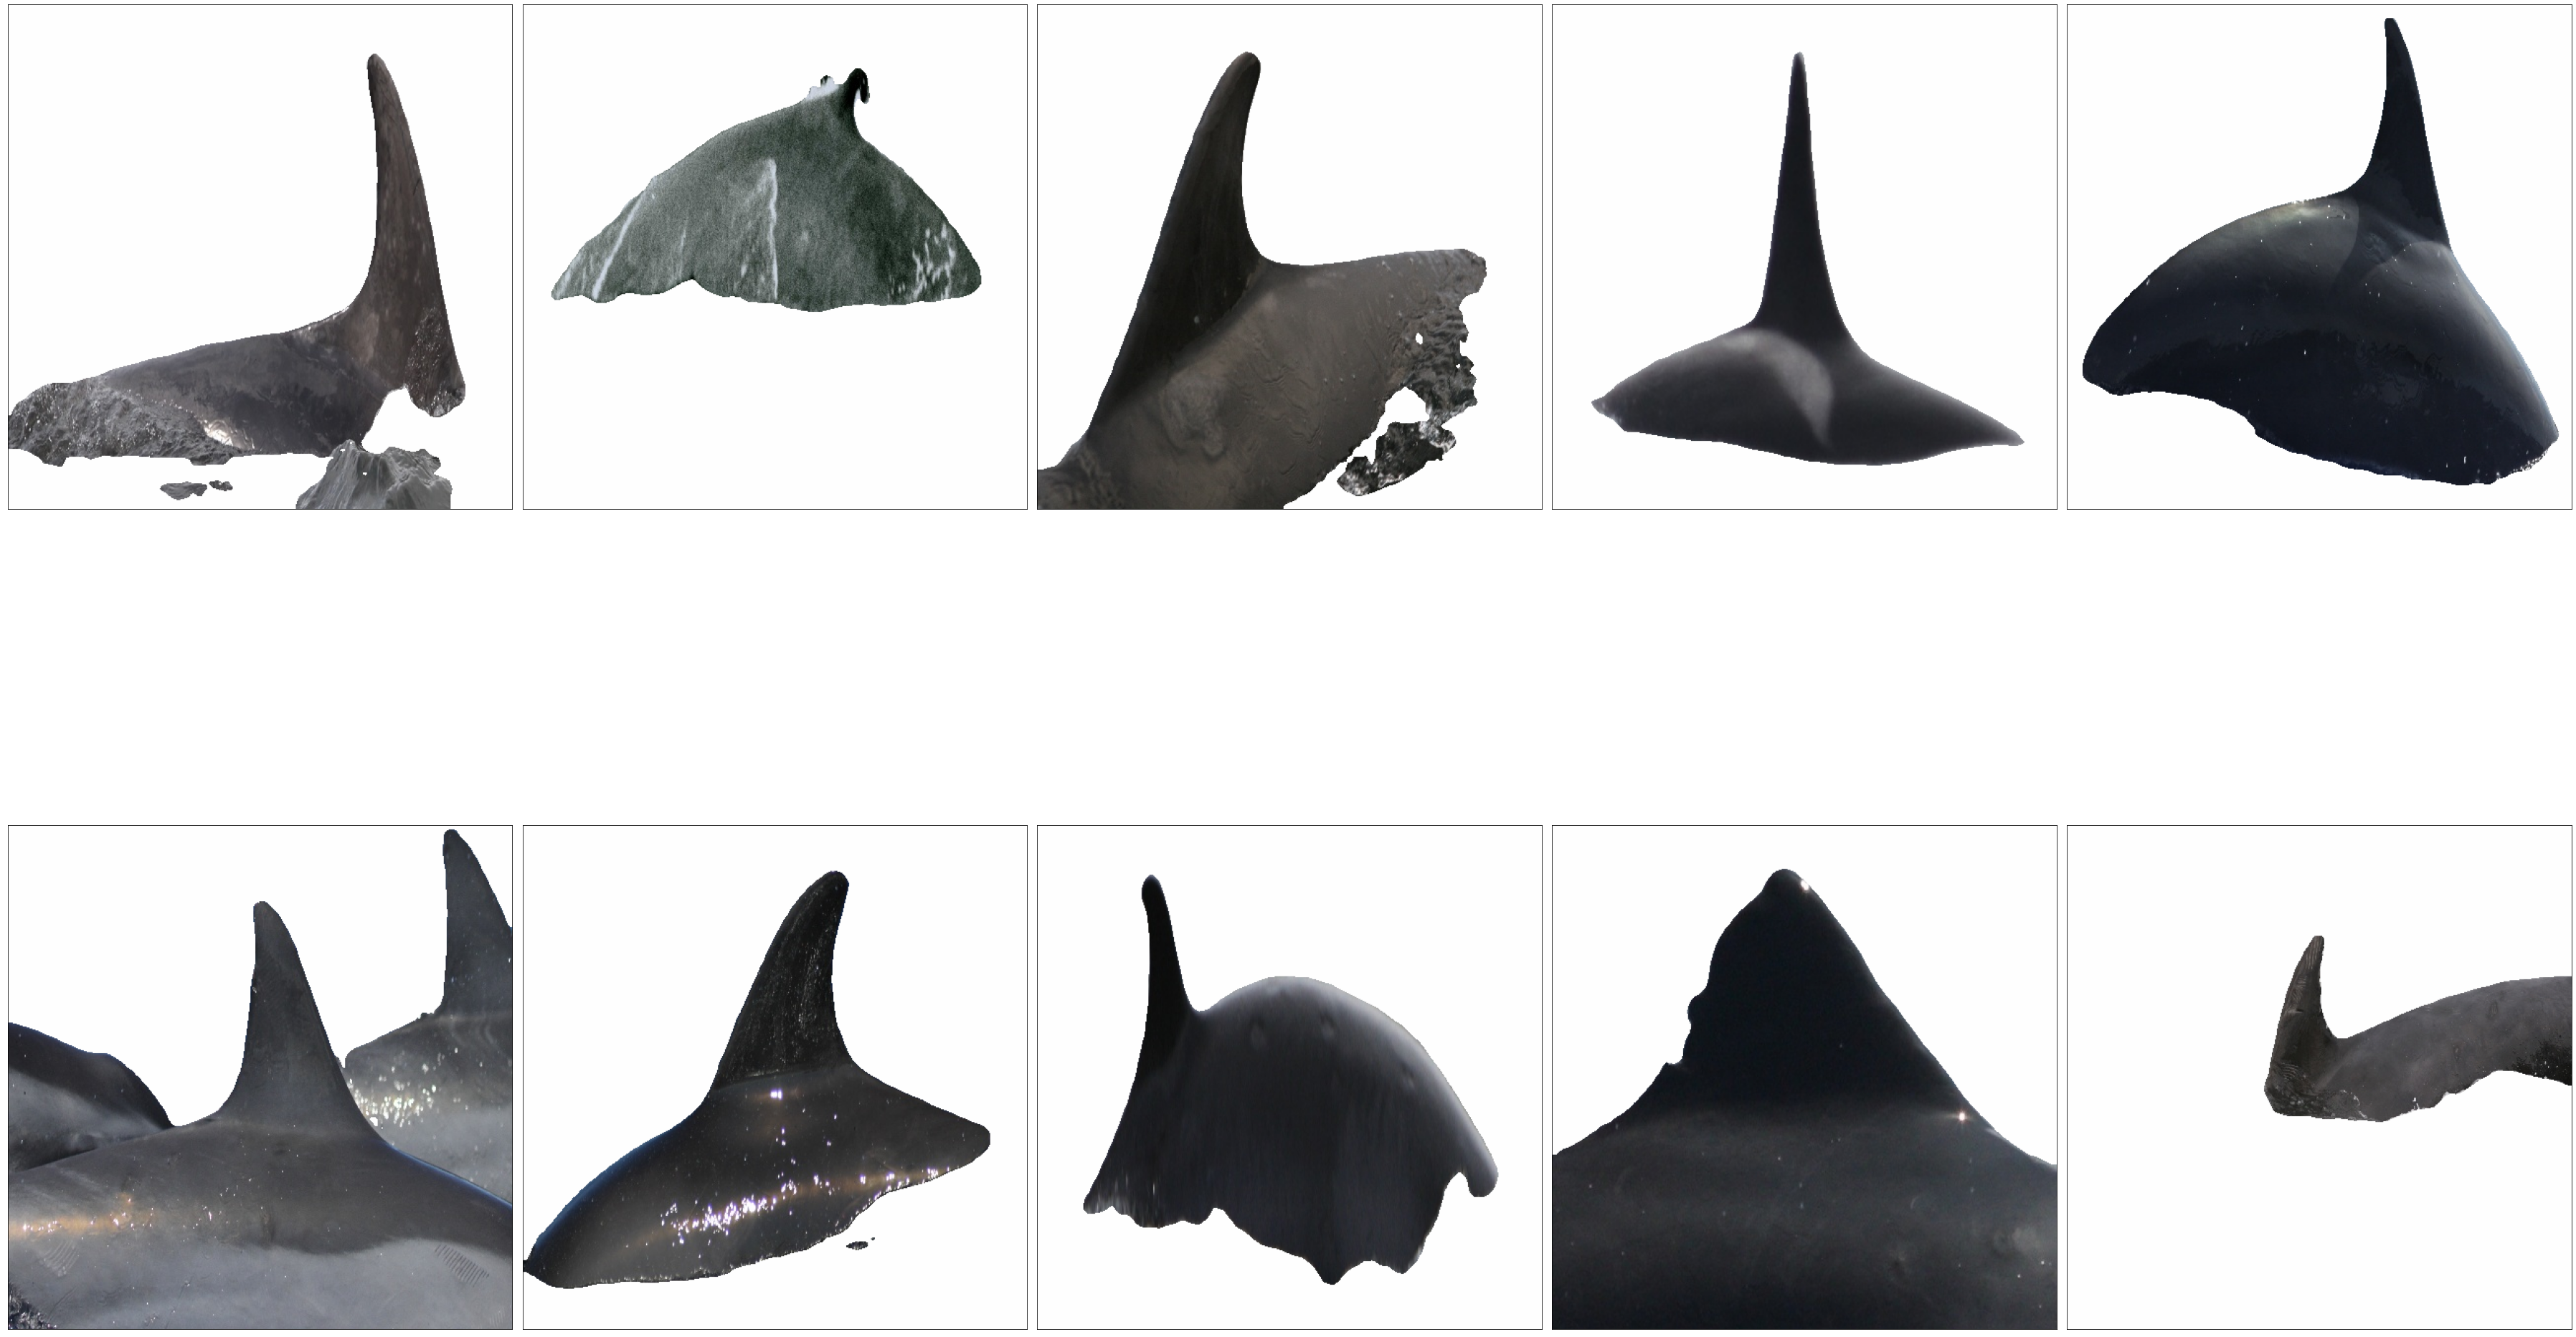

In [28]:
example_images = image_list[:10]
plt.figure(figsize=(50,50))
columns = 5
for i, image in enumerate(example_images):
    plt.subplot(len(example_images) / columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
save_fig("sample_image_plot")
plt.show()

Create Function to transform images into np.array

TODO: adapt code below

In [ ]:
# Importing necessary libraries/functions
from PIL import Image as PIL_Image


# Defining function that performs translation of jpg files into numerical representation
def pixel_transformation(target_pixel, correct_switch):
    # Correct/Incorrect switch
    if correct_switch==True:
            
        # Run-time information
        start_time = timeit.default_timer()
        print(">... Starting pixel transformation for correct pictures for resolution: ", target_pixel, "x", target_pixel)

        # Initialize emtpy array of fitting length
        array_length = target_pixel*target_pixel*3 #Times 3 as we have 3 values (RGB) per pixel
        loaded_pics_correct = np.empty([0,array_length])

        #Running trough all correctly worn image files
        for filename in filepaths_correct:
            # open picture
            pic = PIL_Image.open(filename)
            # Reduce size from original format to target format
            pic_resized = pic.resize((target_pixel, target_pixel))
            # Extract RGB data
            pic_data = np.array(pic_resized)
            # Include help array to reshape 3D-array(e.g.: 1024, 1024, 3) into 1D array
            help_array = np.reshape(pic_data,(pic_data.size,))
            # Stack each array onto each other to have one larger array of shape (#obs,#pixels*3)
            loaded_pics_correct = np.vstack((loaded_pics_correct, help_array))
        
        #End run-time information
        elapsed = timeit.default_timer() - start_time
        print("Finished", target_pixel, "x", target_pixel ,"pixel transformation for correct pictures. Run-time in seconds: ", round(elapsed,2))
 
        # Returning
        return loaded_pics_correct